<a href="https://colab.research.google.com/github/HiagoAD/GDI2/blob/master/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [11]:
!pip install mlflow --quiet
!pip install optuna --quiet
get_ipython().system_raw("mlflow ui --port 5000 &")

!pip install pyngrok --quiet

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

import mlflow

     |████████████████████████████████| 302 kB 4.1 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 141 kB 62.9 MB/s 
     |████████████████████████████████| 111 kB 69.3 MB/s 
Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://4e60fdd20c9b.ngrok.io


## Load datasets


In [3]:
dengue = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/dengue2020.csv", encoding ="UTF-8")
emlurb = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/emlurb2020.csv", encoding ="UTF-8")

dengue19 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/dengue2019.csv", encoding ="UTF-8", error_bad_lines=False)
emlurb19 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/emlurb2019.csv", encoding ="UTF-8")

dengue18 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/dengue2018.csv", encoding ="UTF-8", error_bad_lines=False)
emlurb18 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/emlurb2018.csv", encoding ="UTF-8")

dengue17 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/dengue2017.csv", encoding ="UTF-8", error_bad_lines=False)
emlurb17 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/emlurb2017.csv", encoding ="UTF-8")

dengue16 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/dengue2016.csv", encoding ="UTF-8", error_bad_lines=False)
emlurb16 = pd.read_csv("https://raw.githubusercontent.com/HiagoAD/GDI2/master/datasets/emlurb2016.csv", encoding ="UTF-8")


b'Skipping line 108: expected 126 fields, saw 127\nSkipping line 1485: expected 126 fields, saw 127\nSkipping line 2584: expected 126 fields, saw 127\nSkipping line 4415: expected 126 fields, saw 127\nSkipping line 5659: expected 126 fields, saw 127\nSkipping line 6469: expected 126 fields, saw 127\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (55,113) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Dados de 2020 - 2016


Iremos fazer os mesmos tratamentos anteriores para os dados de 2019 até 2016.

In [4]:
# Dados Dengue

merge_dengue = dengue.append([dengue19,dengue18,dengue17,dengue16], ignore_index = True)
merge_dengue = merge_dengue[["febre", "mialgia",'vomito', "dt_notificacao",'nu_idade','nausea','cefaleia','dor_costas','diabetes','renal']]
merge_dengue['dt_notificacao'] = pd.to_datetime(merge_dengue['dt_notificacao'])

# Agrupamos por número de casos por dia

#merge_dengue = merge_dengue.groupby([pd.Grouper(key="dt_notificacao", freq="D")]).size().reset_index(name="CASOS_DENGUE")


# Dados Emlurb

merge_emlurb = emlurb.append([emlurb19,emlurb18,emlurb17,emlurb16], ignore_index = True)
merge_emlurb = merge_emlurb[["GRUPOSERVICO_CODIGO", "DATA_DEMANDA"]]
merge_emlurb = merge_emlurb[(merge_emlurb.GRUPOSERVICO_CODIGO == 11)]
merge_emlurb["DATA_DEMANDA"] = pd.to_datetime(merge_emlurb["DATA_DEMANDA"],errors='coerce')

# Agrupamos por número de solicitações por dia

#merge_emlurb = merge_emlurb.groupby([pd.Grouper(key="DATA_DEMANDA", freq="D")]).size().reset_index(name="CHAMAD0S_EMLURB")

#year_filter = merge_emlurb[(merge_emlurb['DATA_DEMANDA'].dt.year == 2018)]


merge_dengue = merge_dengue.dropna()
merge_dengue['febre'] = merge_dengue['febre'].astype('int')
merge_dengue['mialgia'] = merge_dengue['mialgia'].astype('int')
merge_dengue['vomito'] = merge_dengue['vomito'].astype('int')
merge_dengue['nausea'] = merge_dengue['nausea'].astype('int')
merge_dengue['cefaleia'] = merge_dengue['cefaleia'].astype('int')
merge_dengue['dor_costas'] = merge_dengue['dor_costas'].astype('int')
merge_dengue['diabetes'] = merge_dengue['diabetes'].astype('int')
merge_dengue['renal'] = merge_dengue['renal'].astype('int')
merge_dengue = merge_dengue.sort_values('dt_notificacao')
merge_dengue

,febre,mialgia,vomito,dt_notificacao,nu_idade,nausea,cefaleia,dor_costas,diabetes,renal
14367,1,1,2,2016-01-03,4024,2,2,2,2,2
13813,2,2,2,2016-01-03,4059,2,2,2,2,2
13658,1,1,2,2016-01-04,4017,1,1,2,2,2
13595,1,1,2,2016-01-04,4031,2,1,2,2,2
13781,1,1,2,2016-01-04,4054,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...
975,1,1,1,2020-07-16,4008,1,1,2,2,2
1007,1,1,2,2020-07-17,4017,2,1,2,2,2
1005,1,2,2,2020-07-19,4010,2,2,2,2,2
1003,1,1,2,2020-07-20,3001,2,2,2,2,2


## Feature de predição

1.   Ocorrência de febre em casos de dengue por dia.
2.   Número de solicitações de drenagem por dia.



## Separação de dados: Treino, Validação e Teste

Os dados estão em ordem temporal, treino usa os primeiros 2/4 dos dados, em seguida 1/4 pra validação e 1/4 para testes.

In [5]:
def split_values(df, column_name):
  X = df.drop(columns=[column_name,'dt_notificacao']).values
  y = df[column_name].values

  return X, y

In [27]:
features_results = merge_dengue.drop(columns=['febre','dt_notificacao'])
labels_results = merge_dengue['febre']

X_train, X_test, y_train, y_test = train_test_split(features_results, labels_results, test_size=0.25, shuffle=False)
X_train, X_valid, y_train, y_valid =  train_test_split(X_train, y_train, test_size=(1/3), shuffle=False)

print(features_results.shape)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(25913, 8)
(12956, 8)
(6479, 8)
(6478, 8)


In [ ]:
# train, validation, test = np.split(merge_dengue.sample(frac=1, random_state=42), [int(.6*len(merge_dengue)), int(.8*len(merge_dengue))])

# column_name = 'febre'

# X_train, y_train = split_values(train, column_name)
# X_valid, y_valid = split_values(validation, column_name)
# X_test,  y_test  = split_values(test, column_name)

X_train, y_train = feature_train, label_train
X_valid, y_valid = feature_validation, label_validation
X_test, y_test = feature_test, label_test

## Escolha de Algoritmos

*   Decision Tree
*   Random Forest
*   Naive Bayes
*   MLP
*   KNN



In [7]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
naive_bayes   = GaussianNB()
ml_perceptron = MLPClassifier()
knn = KNeighborsClassifier()

decision_tree.fit(X_train, y_train)
y_decision_tree_train = decision_tree.predict(X_train)
y_decision_tree_test  = decision_tree.predict(X_test)

random_forest.fit(X_train, y_train)
y_random_forest_train = random_forest.predict(X_train)
y_random_forest_test  = random_forest.predict(X_test)

naive_bayes.fit(X_train, y_train)
y_naive_bayes_train = naive_bayes.predict(X_train)
y_naive_bayes_test  = naive_bayes.predict(X_test)

ml_perceptron.fit(X_train, y_train)
y_ml_perceptron_train = ml_perceptron.predict(X_train)
y_ml_perceptron_test  = ml_perceptron.predict(X_test)

knn.fit(X_train, y_train)
y_knn_train = knn.predict(X_train)
y_knn_test = knn.predict(X_test)

In [8]:
print("=== Precisão Testes === \n\n")

print("Precisão Decision Tree:", accuracy_score(y_test, y_decision_tree_test))
print("Precisão Random Forest:", accuracy_score(y_test, y_random_forest_test))
print("Precisão Naive Bayes:" , accuracy_score(y_test, y_naive_bayes_test))
print("Precisão MLP: ", accuracy_score(y_test, y_ml_perceptron_test))
print("Precisão KNN: ", accuracy_score(y_test, y_knn_test))

print("\n\n=== Precisão Treino === \n\n")

print("Precisão Decision Tree:", accuracy_score(y_train, y_decision_tree_train))
print("Precisão Random Forest:", accuracy_score(y_train, y_random_forest_train))
print("Precisão Naive Bayes:" , accuracy_score(y_train, y_naive_bayes_train))
print("Precisão MLP: ", accuracy_score(y_train, y_ml_perceptron_train))
print("Precisão KNN: ", accuracy_score(y_train, y_knn_train))

=== Precisão Testes === 


Precisão Decision Tree: 0.8789936718629419
Precisão Random Forest: 0.8779132582188609
Precisão Naive Bayes: 0.735144312393888
Precisão MLP:  0.8885630498533724
Precisão KNN:  0.880845809538509


=== Precisão Treino === 


Precisão Decision Tree: 0.8809817845013893
Precisão Random Forest: 0.8809817845013893
Precisão Naive Bayes: 0.7185087990120408
Precisão MLP:  0.7521611608521148
Precisão KNN:  0.8589070700833591


## MLFlow e Hiper-parâmetros

Nessa etapa, adicionaremos o MLFlow e o Optuna para seleção de hiper-parâmetros sobre o conjunto de validação.

In [13]:
from optuna.integration.mlflow import MLflowCallback
mlflc = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="Accuracy",
    
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.



### Decision Tree

In [ ]:
@mlflc.track_in_mlflow()
def objective_decisionTree(trial):
    max_depth = trial.suggest_int("max_depth", 1, 15, 1)
    split     = trial.suggest_int('min_samples_split', 3, 15, 1)
    leaf      = trial.suggest_int('min_samples_leaf', 3, 15, 1)

    decisionTree_selection = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=leaf, min_samples_split=split)
    decisionTree_selection.fit(X_train, y_train)
    
    prediction_validation = decisionTree_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_dt = optuna.create_study(direction="maximize", study_name="Decision Tree")
mlflow.end_run()
study_dt.optimize(objective_decisionTree, n_trials=50, callbacks=[mlflc])
print(study_dt.best_trial)

In [15]:
print(study_dt.best_trial.value)
print(study_dt.best_trial.params)

0.8971904908922507
{'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 13}


### Random Forest

In [ ]:
def objective_randomForest(trial):
    forrest_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    forrest_criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    forrest_max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    randomForrest_selection = RandomForestClassifier(n_estimators=forrest_n_estimators, criterion=forrest_criterion, max_features=forrest_max_features)
    randomForrest_selection.fit(X_train, y_train) 

    prediction_validation = randomForrest_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_rf = optuna.create_study(direction="maximize", study_name="Random Forest")
mlflow.end_run()
study_rf.optimize(objective_randomForest, n_trials=50, callbacks=[mlflc])
print(study_rf.best_trial)

In [ ]:
print(study_rf.best_trial.value)
print(study_rf.best_trial.params)

0.8920963260265514
{'n_estimators': 508, 'criterion': 'entropy', 'max_features': 'auto'}


### Naive Bayes

In [ ]:
def objective_naiveBayes(trial):
    nb_var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e9, log=True)

    naiveBayes_selection = GaussianNB(var_smoothing=nb_var_smoothing)
    naiveBayes_selection.fit(X_train, y_train)     

    prediction_validation = naiveBayes_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_nb = optuna.create_study(direction="maximize", study_name="Neive Bayes")
mlflow.end_run()
study_nb.optimize(objective_naiveBayes, n_trials=50, callbacks=[mlflc])
print(study_nb.best_trial)

In [ ]:
print(study_nb.best_trial.value)
print(study_nb.best_trial.params)

0.8672429762272307
{'var_smoothing': 6199.49291075694}


### MLP

In [ ]:
def objective_MLP(trial):
    layer_size = trial.suggest_int('hidden_layer_sizes', 10, 1000, 10)
    activation = trial.suggest_categorical('activation', ['logistic', 'relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    mlp_selection = MLPClassifier(layer_size, activation=activation, solver=solver)
    mlp_selection.fit(X_train, y_train)     

    prediction_validation = mlp_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_mlp = optuna.create_study(direction="maximize", study_name="MLP")
mlflow.end_run()
study_mlp.optimize(objective_MLP, n_trials=50, callbacks=[mlflc])
print(study_mlp.best_trial)

In [ ]:
print(study_mlp.best_trial.value)
print(study_mlp.best_trial.params)

0.8673973448595246
{'hidden_layer_sizes': 390, 'activation': 'logistic', 'solver': 'adam'}


### KNN

In [ ]:
def objective_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5 , 500)
    knn_selection = KNeighborsClassifier(n_neighbors)
    knn_selection.fit(X_train, y_train)     

    prediction_validation = knn_selection.predict(X_valid)
    accuracy_validation = accuracy_score(y_valid, prediction_validation)

    return accuracy_validation

study_knn = optuna.create_study(direction="maximize", study_name="KNN")
mlflow.end_run()
study_knn.optimize(objective_KNN, n_trials=50, callbacks=[mlflc])
print(study_knn.best_trial)

In [ ]:
print(study_knn.best_trial.value)
print(study_knn.best_trial.params)

0.8931769064526088
{'n_neighbors': 191}


In [ ]:
study_mlp.best_trial.value


0.8673973448595246

## Diagnóstico de melhor modelo

Após os testes realizados com o Random Forest, Decision Tree, Naive Bayes, MLP e KNN, encontramos os seguintes resultados para seus melhores modelos:

*   Decision Tree: 0.8971904908922507
*   Random Forest: 0.8920963260265514
*   Naive Bayes: 0.8672429762272307
*   MLP: 0.8673973448595246
*   KNN: 0.8931769064526088

Sendo assim, a Decision Tree foi a que teve a maior acurácia, com o modelo abaixo sendo o melhor encontrado, usaremos esses valores para testar contra o grupo de testes.


In [17]:
#{'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 8}

max_depth = 8
split     = 6
leaf      = 8

decisionTree_selection = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=leaf, min_samples_split=split)
decisionTree_selection.fit(X_train, y_train)

y_test_prediction   = decisionTree_selection.predict(X_test)
accuracy_validation = accuracy_score(y_test, y_test_prediction)

Precisão Decision Tree
0.8857848433400216


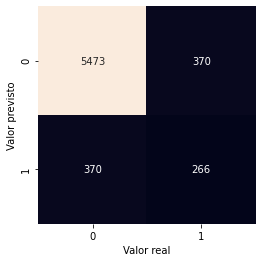

In [28]:
confusionMatrix = confusion_matrix(y_test, y_test_prediction)

sns.heatmap(confusionMatrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Valor real')
plt.ylabel('Valor previsto');

print("Precisão Decision Tree")
print(accuracy_validation)

### Columns importance

Verificamos o nível de relevância das colunas do dataset.

In [30]:
column_importance = pd.DataFrame({'column': X_train.columns, 'column_importance': decisionTree_selection.feature_importances_})
column_importance = column_importance.sort_values('column_importance', ascending=False).reset_index(drop=True)
column_importance

,column,column_importance
0,cefaleia,0.474449
1,mialgia,0.336682
2,vomito,0.111698
3,nu_idade,0.045331
4,nausea,0.027116
5,dor_costas,0.003637
6,diabetes,0.001086
7,renal,0.000000


Text(0.5, 1.0, 'Column Importance')

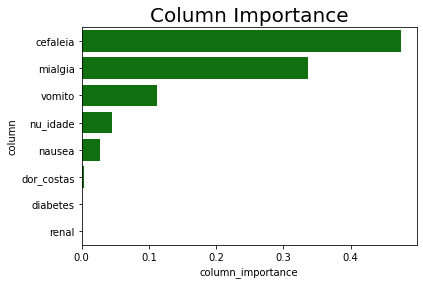

In [31]:
sns.barplot(x = 'column_importance', y='column', data=column_importance, orient='h', color='green').set_title('Column Importance', fontsize = 20)